# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

Импорт полезных библиотек:

In [148]:
import nltk
import numpy as np
import sys
import os.path
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pickle
import time
from datetime import datetime
import dateutil.parser
import re
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

Авторизация в API:

In [2]:
import twitter

CONSUMER_KEY = "4xyvGkRXywfNoGGSVXS4rH3ID"
CONSUMER_SECRET = "jhde8Ub0sTumu14qJOnOldar8cjaNHBvEeW7XFJWvnEnjh6EoQ"

ACCESS_TOKEN_KEY = "153428737-ZrPaCcW71iR4pOj5KXwoIqbaNVF8qHq2RzWAi2JY"
ACCESS_TOKEN_SECRET = "zKcFt0wSRYAAxs1DGS9ji9S14LK0oxPgoNbXXshVUDH9i"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Функция, возвращающая список твитов пользователя. Каждый твит - словарь.

In [3]:
def get_user_tweets(uid):
    tweets = api.GetUserTimeline(user_id = uid, count = 200, include_rts = False, exclude_replies = True)
    tweets_texts = list()
    for i in range(len(tweets)):
        t = tweets[i].AsDict()['text']
        # filter links
        if 'urls' in tweets[i].AsDict():
            for j in tweets[i].AsDict()['urls']:
                t = re.sub(i, "", t)
        if t != u"":
            tweets_texts.append(tweets[i].AsDict())
    return tweets_texts

Функция, возвращающая список слов из текста. Из текста удаляются e-mailы, знаки пунктуации, а также знаки дефиса/тире в окружении пробелов.

In [4]:
def get_words(text):
    t = text.lower()
    # filter possible e-mails
    t = re.sub(r"((^|\w)[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+(\w|$))", "", t)
    t = re.sub(r"[^\w\s'#-]", " ", t) # filter punctuation marks
    t = re.sub(r"([-—−]\s|\s[-—−])", " ", t) # filter dashes with spaces
    t = re.sub("\s+"," ", t) # remove multiple whitespaces
    t = re.sub("(^\s+|\s+$)", "", t) # remove spaces in the beginning and the end
    t = t.split(' ')
    return t

Функция, возвращающая список лемм из списка слов, за исключением наиболее популярных (стоп-слова).

In [5]:
wnl = WordNetLemmatizer()
sw = stopwords.words('english')

def get_tokens(words):
    tokens = list(set(words) - set(sw))
    for i in range(len(tokens)):
        tokens[i] = wnl.lemmatize(tokens[i])
    return tokens

Суперпозиция:

In [6]:
def get_tweet_tokens(tweet):
    return get_tokens(get_words(tweet))

Функция, возвращающая список токенов из твитов всех пользователей датафрейма. Анализируются только твиты на английском языке.
Возможные ошибки, которые могли возникнуть в процессе:
* Not authorized - в случае, когда твиты пользователя недоступны публично, либо аккаунт был удалён.
* Code 34 - пользователя с таким id не существует.
* Code 88 - превышен лимит 180 запросов за 15 минут

In [7]:
def collect_users_tokens(df_users):
    
    users = list()
    users_tokens = list()
    user_set = set(df_users['uid'])
    
    while len(user_set) > 0:
        try:
            current_user = user_set.pop()
            current_user_tweets = api.GetUserTimeline(current_user, count = 200)
        except Exception as e:
            print datetime.now().strftime('%d/%m/%Y %H:%M:%S')
            print "User:", current_user
            print "Caught error: ", str(e)
            if 'code' in e[0][0]:
                if e[0][0]['code'] == 34: # page does not exist
                    print "User with id", current_user,"does not exist, sorry :c"
                elif e[0][0]['code'] == 88: # more than 180 requests per 15 minutes
                    sleep_time = api.GetSleepTime('statuses/user_timeline')
                    print "Waiting", sleep_time, "seconds... Total proceeded so far:", len(users)
                    user_set.add(current_user) # back in set
                    time.sleep(sleep_time + 1) # time to get some tea
        else:
            users.append(current_user)
            current_user_dict = {}
            for i in xrange(len(current_user_tweets)):
                if current_user_tweets[i].lang == 'en': # since we analyse only english tweets
                    current_user_tokens = get_tweet_tokens(current_user_tweets[i].text)
                    for token in current_user_tokens:
                        if token not in current_user_dict:
                            current_user_dict[token] = 1
                        else:
                            current_user_dict[token] += 1
            users_tokens.append(current_user_dict)
    return users, users_tokens

Непосредственное выкачивание. Итоговый результат сохранён в файлы users.arr и users_tokens.arr и загружается автоматически, если файлы лежат в одной директории с данным ноутбуком.

Подробный вывод функции процесса выкачивания твитов лежит в репозитории в файле collect_tweets_output.txt

In [8]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.index = range(len(df_users_train) + len(df_users_ex)) # continuing indexing from len(df_users_train)

# Loading users and tokens either from twitter or from stored data (if exists)
if os.path.isfile("users.arr") and os.path.isfile("users_tokens.arr"):
    fileusers = open("users.arr", "rb")
    users = pickle.load(fileusers)
    fileusers.close()
    fileuserstokens = open("users_tokens.arr", "rb")
    users_tokens = pickle.load(fileuserstokens)
    fileuserstokens.close()
else:
    users, users_tokens = collect_users_tokens(df_users)
    print "Successfully collected tweets from", len(users),"users."
    fileusers = open("users.arr","wb")
    pickle.dump(users, fileusers)
    fileusers.close()
    fileuserstokens = open("users_tokens.arr","wb")
    pickle.dump(users_tokens, fileuserstokens)
    fileuserstokens.close()

Создание разреженной матрицы, где строки соответствуют обработанным пользователям, а столбцы - токенам.

In [9]:
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

Сохранение в файл на будущее.

In [12]:
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens)

Наглядное облако токенов всех пользователей:

In [185]:
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import wordcloud

def draw_tag_cloud(tokens_list, tags_number = 150):
    c = Counter()
    for i in xrange(len(tokens_list)):
        c.update(tokens_list[i])
    
    parrot_mask = np.array(Image.open("macaw_mask.jpg"))
    swords = set()
    swords.add("http") # for some reason
    swords.add("amp")  # several url parts
    swords.add("co")   # were not filtered
    swords.add("rt")   # so delete them manually
    wc = wordcloud.WordCloud(background_color = "white", max_words = tags_number, mask = parrot_mask,
                             stopwords = swords,random_state = 42)
    s = ""
    for key in c.most_common(tags_number):
        s += (key[0] + ' ') * key[1]
    
    wc.generate(s)
    image_colors = wordcloud.ImageColorGenerator(parrot_mask)
    plt.figure(figsize = (20,12))
    plt.imshow(wc.recolor(color_func=image_colors))
    plt.axis("off")
    plt.show()
    return

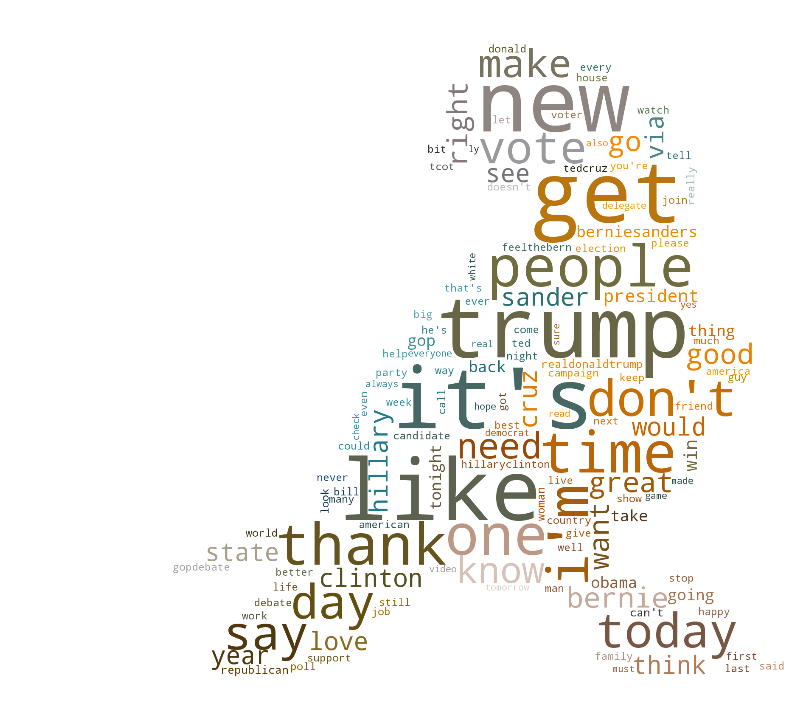

In [186]:
draw_tag_cloud(users_tokens)